<a href="https://colab.research.google.com/github/abj360/nimbus-app/blob/main/Nimbus_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note: Change Hardware Accelerator to GPU to train faster (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)**

# Nimbus - Machine Learning App for Colorectal Cancer Diagnosis

In [ ]:
# @title # **Run this code cell to set up the notebook!**
# @markdown The data may take some time to load in, so feel free to move on to the next part in the meantime.

project = "histology"
import requests
from IPython.display import Markdown, display

import tensorflow_datasets as tfds
from tensorflow.image import resize_with_pad, ResizeMethod

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def ProjectDescription(project):
  display_str =  f"**[{project.capitalize()} Project Background Document]({article_url_dict[project]})** <br />"
  display_str += f"**[{project.capitalize()} Dataset Documentation]({dataset_documentation_url_dict[project]})** <br />"
  display(Markdown(display_str))
  response = requests.get(image_url_dict[project], stream=True)
  img = Image.open(response.raw)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

def plot_metric(history, metric="accuracy", best_is_max=True, start_epoch=0, random_model_metric=None):
  # Get lists of accuracies over the epochs
  training_accuracy = history.history[metric][start_epoch:]
  validation_accuracy = history.history['val_' + metric][start_epoch:]

  # Find best epoch depending on whether max is the best for the metric
  if best_is_max:
    best_epoch = validation_accuracy.index(max(validation_accuracy))
  else:
    best_epoch = validation_accuracy.index(min(validation_accuracy))

  # Plot labels
  plt.title(metric.capitalize() + ' as Model Trains')
  plt.xlabel('Epoch #')
  plt.ylabel(metric.capitalize())

  # Plot lines
  plt.plot(training_accuracy, label='Train')
  plt.plot(validation_accuracy, label='Validation')
  plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best Epoch')

  if random_model_metric is not None:
    plt.axhline(random_model_metric, linestyle='--',color='red', label='Chance')

  # Plot legend and show
  plt.legend()
  plt.show()

# URL dictionaries for the projects
article_url_dict = {
    "beans"     : "https://docs.google.com/document/d/19AcNUO-9F4E9Jtc4bvFslGhyuM5pLxjCqKYV3rUaiCc/edit?usp=sharing",
    "malaria"   : "https://docs.google.com/document/d/1u_iX2oDrEZ1clhFefpP3V8uwAjf7EUV4G6kq_3JDcVY/edit?usp=sharing",
    "histology" : "https://docs.google.com/document/d/162WhUE9KqCgq_I7-VvENZD2n1IVsbeXVRSwfJEkxAqQ/edit?usp=sharing",
    "bees"      : "https://docs.google.com/document/d/1PUB_JuYHi6zyHsWAhkIb7D7ExeB1EfI09arc6Ad1bUY/edit?usp=sharing"
}

image_url_dict = {
    "beans"     : "https://storage.googleapis.com/tfds-data/visualization/fig/beans-0.1.0.png",
    "malaria"   : "https://storage.googleapis.com/tfds-data/visualization/fig/malaria-1.0.0.png",
    "histology" : "https://storage.googleapis.com/tfds-data/visualization/fig/colorectal_histology-2.0.0.png",
    "bees"      : "https://storage.googleapis.com/tfds-data/visualization/fig/bee_dataset-bee_dataset_300-1.0.0.png"
}

download_url_prefix_dict = {
    "histology" : "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Towards%20Precision%20Medicine/",
    "bees"      : "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Safeguarding%20Bee%20Health/"
}

dataset_documentation_url_dict = {
    "beans"     : "https://www.tensorflow.org/datasets/catalog/beans",
    "malaria"   : "https://www.tensorflow.org/datasets/catalog/malaria",
    "bees"      : "https://www.tensorflow.org/datasets/catalog/bee_dataset",
    "histology" : "https://www.tensorflow.org/datasets/catalog/colorectal_histology",
}

# Load dataset
if project == "Choose your dataset!":
  print("Please choose your dataset from the dropdown menu!")

elif project == "beans":
  data,  info = tfds.load('beans', split='train[:1024]', as_supervised=True, with_info=True)
  feature_dict = info.features['label'].names
  images = np.array([resize_with_pad(image, 128, 128, antialias=True) for image,_ in data]).astype(int)
  labels = [feature_dict[int(label)] for image,label in data]

elif project == "malaria":
  data,  info = tfds.load('malaria', split='train[:1024]', as_supervised=True, with_info=True)
  images = np.array([resize_with_pad(image, 256, 256, antialias=True) for image,_ in data]).astype(np.uint8)
  labels = ['malaria' if label==1 else 'healthy' for image,label in data]

else:
  wget_command = f'wget -q --show-progress "{download_url_prefix_dict[project]}'
  !{wget_command + 'images.npy" '}
  !{wget_command + 'labels.npy" '}

  images = np.load('images.npy')
  labels = np.load('labels.npy')

  !rm images.npy labels.npy


# Original preprocessing code for datasets

# if project == "histology":
#   data,  info = tfds.load('colorectal_histology', split='train[:1024]', as_supervised=True, with_info=True)
#   feature_dict = info.features['label'].names
#   images = np.array([image for image,label in data]).astype(int)
#   labels = [feature_dict[int(label)] for image,label in data]

# if project == "bees":
#   data,  info = tfds.load('bee_dataset', split='train[:3200]', as_supervised=True, with_info=True)
#   data = [(image, label) for image,label in data if label['wasps_output']==0]
#   data1 = [(image, label) for image,label in data if label['varroa_output']==0][:500]
#   data2 = [(image, label) for image,label in data if label['varroa_output']==1][:500]
#   data = data1 + data2
#   images = np.array([image for image, _ in data]).astype(int)
#   labels = ['diseased' if label['varroa_output'] else 'healthy' for image,label in data]

images.npy          100%[===================>] 527.34M   114MB/s    in 7.5s    
labels.npy          100%[===================>]  28.12K  --.-KB/s    in 0s      


# PART 1: Tissue Classification

Let's construct a machine learning model to diagnose colorectal cancer!

##Exploring Our Data

Our histological images are stored in `images`, and our corresponding labels are stored in `labels`. Let's take a look at them

---




In [ ]:
#@title Dataset Shape
dimensions = np.shape(images) # using np.shape
dimensions = images.shape # using shape attribute since images is already an np array

print('Dimensions of dataset:', dimensions)
X_train, X_test, y_train, y_test = train_test_split(images, labels)

Dimensions of dataset: (1024, 150, 150, 3)


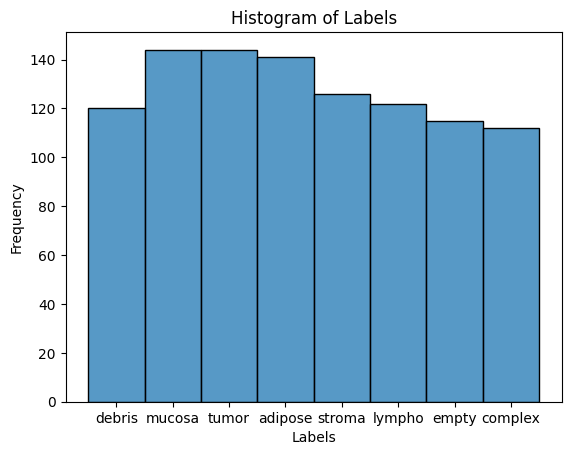

In [ ]:
#@title Labels and their frequency
sns.histplot(labels)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

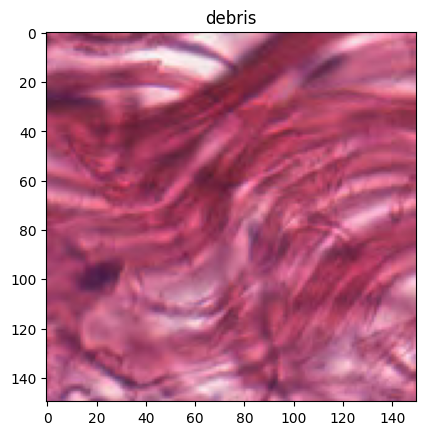

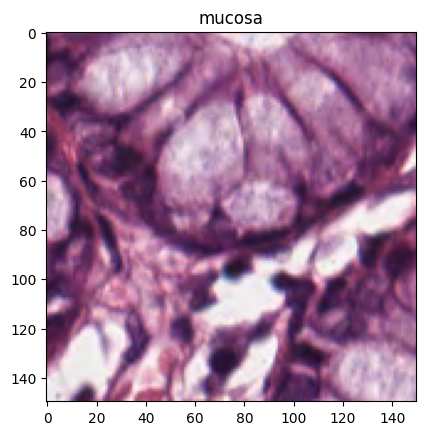

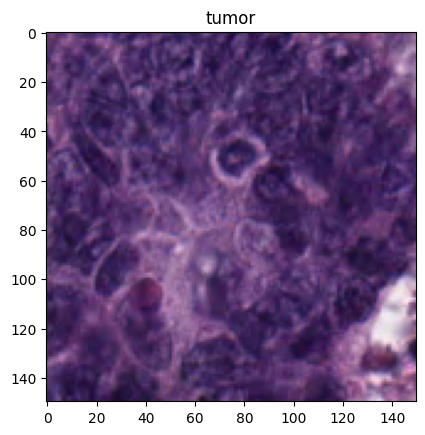

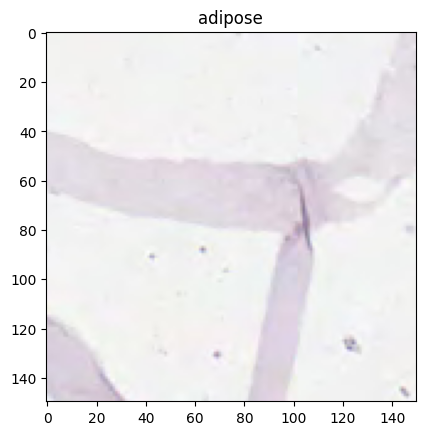

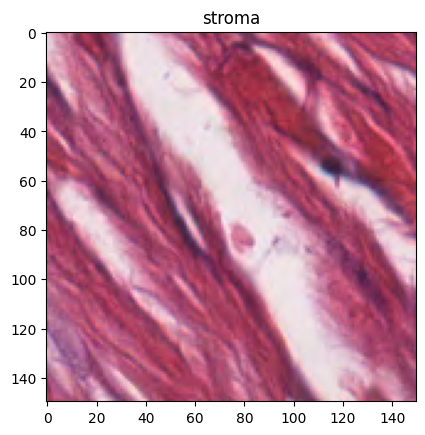

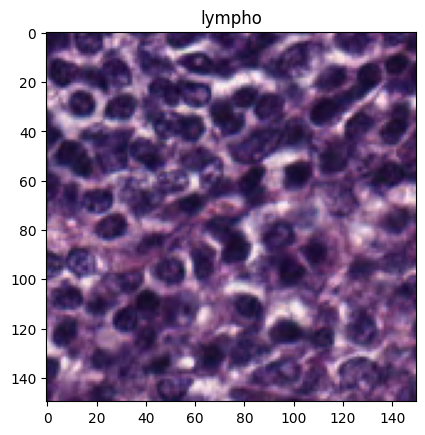

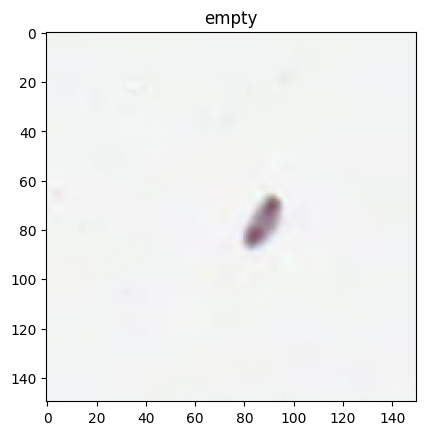

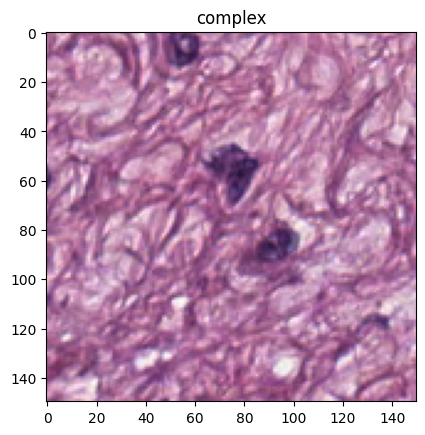

In [ ]:
#@title Images and their distinctive labels
num_unique_labels = len(np.unique(labels))
labels_used_so_far = []
i = 0
while len(labels_used_so_far) < num_unique_labels:
  if labels[i] not in labels_used_so_far:
    plt.imshow(images[i]) # Use matplotlib imshow() function to visualize an image.
    plt.title(labels[i]) # Set the label of the image as the title
    plt.show() # Show your plot.
    labels_used_so_far.append(labels[i])
  i = i + 1

##Processing Our Data



In [45]:
#@title One hot encoding!
import pickle
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv3D, Flatten

# Using the get_dummies() function to one-hot encode your labels.
labels_ohe = np.array(pd.get_dummies(labels))

# Select your feature (X) and labels (y).
y = labels_ohe
X = images

# Save the labels to a file
with open("labels.pkl", "wb") as f:
    pickle.dump(labels, f)
with open("labels_ohe.pkl", "wb") as f:
    pickle.dump(labels_ohe, f)

print("Labels saved successfully!")


Labels saved successfully!


In [ ]:
#@title Train-test-split
# Split your data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('Dim X_train:', X_train.shape)
print('Dim y_train:', y_train.shape)
print('Dim X_test:', X_test.shape)
print('Dim y_test:', y_test.shape)

Dim X_train: (819, 150, 150, 3)
Dim y_train: (819, 8)
Dim X_test: (205, 150, 150, 3)
Dim y_test: (205, 8)


##Transfer Learning


For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available.

Below, we see examples of 3 different categories.

![](https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/ImageNet.jpg)

This model will already have some object recognition expertise baked into it! We'll utilize this expertise by loading in this model, and we'll adapt it to our problem by replacing the last layer with a layer that we'll train ourselves.


Run the next cell to perform step 1, intializing one this large model.

Additionally, look at the summary of the model and answer:
- What is the input size of the images that VGG16 can classify?
- How many different categories of images does VGG16 classify?
- How many different weights (parameters) did VGG16 learn when it was originally trained?

In [ ]:
#@title Initialize our model!
# Run this cell to import pretrained MobileNet
from keras.applications import MobileNetV2, VGG16
mobile_net = VGG16(include_top=True)
mobile_net.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

###🧰 Modifying the output layer size


In [ ]:
from keras import Model

# Make a final layer. Use a Dense() layer, with the size as
# the number of of classes you want to predict!
# Also set the activation function to softmax.
new_output_layer = Dense(len(y_train[0]), activation='softmax')

# Rewire the model so that the new output layer
# The syntax here can be a little confusing, so we've helped you out.
output = new_output_layer(mobile_net.layers[-2].output)
input = mobile_net.input
transfer_cnn = Model(input, output)

# print the summary
transfer_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,293,320 (512.29 MB)

 Trainable params: 134,293,320 (512.29 MB)

 Non-trainable params: 0 (0.00 B)

### 🧊 Freezing the weights

Next, freeze the weights for all of the layers except for the final layer. You can do this by setting
```layer.trainable=False``` where ```layer``` is the layer you are interested in freezing (``trainable=False``) or unfreezing (``trainable=True``) the weights of.

Additionally, compile your model and look at its summary.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# make all layers untrainable by freezing weights (except for last layer)
for layer in transfer_cnn.layers:
    layer.trainable = False

## Set the final layer as trainable=True
transfer_cnn.layers[-1].trainable = True


# Define ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("nimbus_model.keras", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

# Compile the model
transfer_cnn.compile(loss='categorical_crossentropy', optimizer='adam',
                     metrics=['accuracy', 'categorical_crossentropy'])
# Look at the summary of the network to make sure the structure is as you expect!
transfer_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,293,320 (512.29 MB)

 Trainable params: 32,776 (128.03 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

### ✂ Resize your images

Let's resize our images so that they are the appropriate size for the input layer of your model.


In [ ]:
def ResizeImages(images, height, width):
  return np.array([resize_with_pad(image, height, width, antialias=True) for image in images]).astype(int)

X_train_resized = ResizeImages(X_train, 224, 224)
X_test_resized = ResizeImages(X_test, 224, 224)

# Make sure your images are the right dimensions
print("Dim X_train_resized:", X_train_resized.shape)
print("Dim X_test_resized:", X_test_resized.shape)

Dim X_train_resized: (819, 224, 224, 3)
Dim X_test_resized: (205, 224, 224, 3)


### 💅 Finetune the model using your data

Finally, train your model using your data. Because this model takes a while to train, just train for 10 epochs. Use the testing data as validation to look at model performance as it trains.

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 821ms/step - accuracy: 0.5146 - categorical_crossentropy: 1.6228 - loss: 1.6228 - val_accuracy: 0.7805 - val_categorical_crossentropy: 0.6189 - val_loss: 0.6189
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.8208 - categorical_crossentropy: 0.4996 - loss: 0.4996 - val_accuracy: 0.8098 - val_categorical_crossentropy: 0.5258 - val_loss: 0.5258
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.9070 - categorical_crossentropy: 0.2524 - loss: 0.2524 - val_accuracy: 0.8585 - val_categorical_crossentropy: 0.5334 - val_loss: 0.5334
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.9363 - categorical_crossentropy: 0.2082 - loss: 0.2082 - val_accuracy: 0.8439 - val_categorical_crossentropy: 0.4768 - val_loss: 0.4768
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.9601 - categorical_crossentropy: 0.1465 - loss: 0.1465 - val_accuracy: 0.8537 - val_categorical_crossentropy: 0.4604 - val

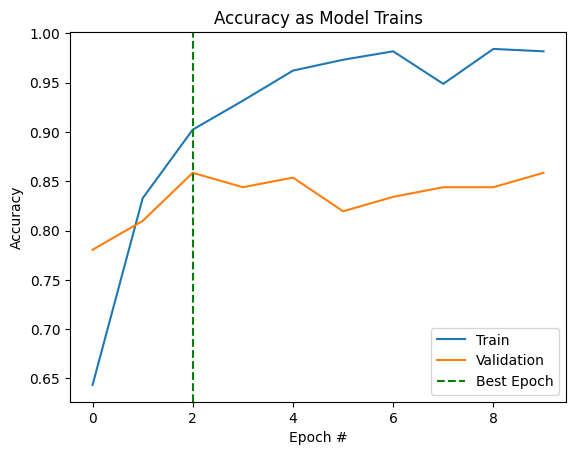

In [ ]:
transfer_history = transfer_cnn.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=10)
plot_metric(transfer_history)

###Evaluating the Model's Accuracy

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and plot accuracy/loss curves."""
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")
evaluate_model(transfer_cnn, X_test_resized, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8840 - categorical_crossentropy: 0.3983 - loss: 0.3983
Test Loss: 0.4808, Test Accuracy: 0.8585


### Saving the Model


In [ ]:
from google.colab import files

transfer_cnn.save("nimbus_model.keras")

files.download("nimbus_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PART II: Setting Up Our Healthcare App

Congrats!!! You used some very advanced techniques to build a sophisticated machine learning model! Now let's go on and build the user interface

<img src="https://c.pxhere.com/photos/04/45/fireworks_celebration_bright_pink_explosive_celebrate_display_july_4th-1160027.jpg!d" width=500>



### Setting up Ngrok auth token

In [50]:
!pip -q install pyngrok > /dev/null
!pip -q install streamlit > /dev/null
!pip -q install patool > /dev/null
!pip -q install keras==3.5.0 > /dev/null
!ngrok authtoken 2stAYuQD6aIsjzhXhLPLZR7KiMI_5j5bT8XEFmzBwWtLFV72L

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### Connecting Our App and Model

Let's connect our app to our model, so that the user can upload an image, the model will analyze the image, and finally the app will display the classification result with some text.

In [53]:
import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import patoolib
import streamlit as st

from joblib import dump
from tqdm import tqdm
from pyngrok import ngrok

# Helpful function for launching our Streamlit app
def launch_website():
  print ("Click this link to try your web app:")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  tunnel = ngrok.connect()
  print(tunnel.public_url)
  !streamlit run --server.port 80 app.py > /dev/null
launch_website()

Click this link to try your web app:
https://5a65-34-19-51-187.ngrok-free.app
2025-02-12 13:03:40.225363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739365420.249070   30121 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739365420.256766   30121 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 13:03:43.286130: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1739365423.286311   30121 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5508 MB memory:  -> 

###Designing the interface

In [52]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import pickle
import pandas as pd
# Load the trained model
model = tf.keras.models.load_model("nimbus_model.keras")

# Load the labels from the file
with open("labels.pkl", "rb") as f:
    labels = pickle.load(f)
with open("labels_ohe.pkl", "rb") as f:
    labels_ohe = pickle.load(f)

labels_ohe = np.array(labels_ohe)  # conversion using np.array()
one_hot_encoding_to_label_dict = {np.argmax(ohe): label for ohe, label in zip(labels_ohe, labels)}

def predict(image):
    """Preprocesses the image and makes a prediction."""
    small = cv2.resize(image, (224, 224))
    small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    small = np.array([small]) / 255.0  # Normalize

    prob_vector = model.predict(small)[0]
    class_index = np.argmax(prob_vector)
    class_name = one_hot_encoding_to_label_dict[class_index]
    confidence = prob_vector[class_index] * 100  # Convert to percentage

    return class_name, confidence
# Streamlit UI
st.set_page_config(page_title="Nimbus - Colorectal Cancer Diagnosis", layout="centered")
st.title("🌩 Nimbus: AI-Powered Cancer Diagnosis")
st.write("Upload an image to analyze for colorectal cancer.")

# Upload file
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Read and display image
    image = Image.open(uploaded_file)
    image_np = np.array(image)
    st.image(image, caption="Uploaded Image", use_container_width=True)

    # Predict
    with st.spinner("Analyzing image..."):
        class_name, confidence = predict(image_np)

    # Display results
    st.success(f"**Prediction:** {class_name}")
    st.info(f"**Confidence:** {confidence:.2f}%")

    # Provide additional guidance
    st.warning("⚠️ Please consult a medical professional for further evaluation.")

st.markdown("---")
st.caption("*Disclaimer: This tool is for informational purposes only and not a substitute for professional medical advice.*")

Overwriting app.py
